In [1]:
#install and import
# Install SHAP for explainability
!pip install shap --quiet

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Machine learning utilities
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# PyTorch for sequence modeling
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# SHAP for feature-level explanation
import shap

# GPU availability check (optional)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [3]:
#generate synthetic multivariate sensor
# Synthetic dataset generation replicating industrial sensor data
# Includes trend, multiple seasonality components, and noise effects

def generate_synthetic_multivariate_series(n_steps: int = 2000) -> pd.DataFrame:
    t = np.arange(n_steps)

    # Trend component reflecting gradual changes in sensor behavior
    base_trend = 0.01 * t

    # Periodic seasonal components with varying frequencies
    seasonal_1 = 2.0 * np.sin(2 * np.pi * t / 50)
    seasonal_2 = 1.5 * np.sin(2 * np.pi * t / 30)
    seasonal_3 = 1.0 * np.sin(2 * np.pi * t / 70)

    # Gaussian noise to represent sensor disturbance and instability
    noise = [np.random.normal(scale=s, size=n_steps) for s in [0.5,0.3,0.2,0.7,0.5]]

    # Construct five correlated sensors
    sensor_1 = base_trend + seasonal_1 + noise[0]
    sensor_2 = 0.5 * base_trend + seasonal_2 + noise[1]
    sensor_3 = -0.3 * base_trend + seasonal_3 + noise[2]
    sensor_4 = 0.1 * base_trend + 0.5 * seasonal_1 + noise[3]
    sensor_5 = 0.2 * base_trend - 0.3 * seasonal_2 + noise[4]

    # Target is the next value of sensor_1
    target = np.roll(sensor_1, -1)

    df = pd.DataFrame({
        "sensor_1": sensor_1[:-1],
        "sensor_2": sensor_2[:-1],
        "sensor_3": sensor_3[:-1],
        "sensor_4": sensor_4[:-1],
        "sensor_5": sensor_5[:-1],
        "target":   target[:-1]
    })
    return df

df = generate_synthetic_multivariate_series()
df.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target
0,-0.792854,-0.007253,-0.224554,0.154889,0.033756,0.036307
1,0.036307,-0.015995,0.194051,0.399544,-0.646499,0.923099
2,0.923099,0.680706,0.435713,1.098421,-0.100842,0.567805
3,0.567805,0.728915,0.167473,0.536237,-0.800258,0.957621
4,0.957621,0.838585,0.238551,0.892063,-0.156099,1.347117


In [6]:
#windowing scaling and data split
# Create overlapping sequence windows for LSTM input
def create_windows(features, targets, seq_len=30, horizon=1):
    X, y = [], []
    for start in range(len(features) - seq_len - horizon + 1):
        end = start + seq_len
        X.append(features[start:end, :])
        y.append(targets[end + horizon - 1])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

feature_cols = ["sensor_1","sensor_2","sensor_3","sensor_4","sensor_5"]
target_col = "target"

scaler = StandardScaler()
features_scaled = scaler.fit_transform(df[feature_cols].values)
target = df[target_col].values

SEQ_LEN = 30
X_all, y_all = create_windows(features_scaled, target, seq_len=SEQ_LEN)

# Chronological split to avoid leakage
n = len(X_all)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val,   y_val   = X_all[train_end:val_end], y_all[train_end:val_end]
X_test,  y_test  = X_all[val_end:],          y_all[val_end:]


In [5]:
#pytorch dataset and data loader
class TimeSeriesDataset(Dataset):
    # Wraps numpy arrays into PyTorch dataset format
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().unsqueeze(-1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def make_loaders(batch):
    return (
        DataLoader(TimeSeriesDataset(X_train, y_train), batch, shuffle=True),
        DataLoader(TimeSeriesDataset(X_val, y_val), batch, shuffle=False),
        DataLoader(TimeSeriesDataset(X_test, y_test), batch, shuffle=False),
    )


In [7]:
#lstm moddel
# LSTM model extracts temporal correlations from sequence data
class LSTMForecaster(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # last hidden state → output

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]  # use the final timestep hidden representation
        return self.fc(last)


In [8]:
#Train one confiquration
def train_one_model(config, epochs=40, patience=5):
    batch, hidden, layers, lr = config.values()
    train_loader, val_loader, _ = make_loaders(batch)

    model = LSTMForecaster(X_all.shape[2], hidden, layers).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_mae = float("inf")
    best_state = None
    wait = 0

    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optim.zero_grad()
            loss_fn(model(xb), yb).backward()
            optim.step()

        # Evaluate on validation set
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                p = model(xb.to(device)).cpu().numpy()
                preds.append(p)
                trues.append(yb.numpy())
        val_mae = mean_absolute_error(np.vstack(trues), np.vstack(preds))

        # Early stopping
        if val_mae < best_mae - 1e-4:
            best_mae = val_mae
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    model.load_state_dict(best_state)
    return model, best_mae


In [9]:
#hyperparameter
configs = [
    {"batch":32,"hidden":64,"layers":2,"lr":0.001}
]

best_model, best_val_mae = None, float("inf")

for cfg in configs:
    model, mae = train_one_model(cfg)
    best_model, best_cfg, best_val_mae = model, cfg, mae

print("Best config:", best_cfg)
print("Best Validation MAE:", best_val_mae)


Best config: {'batch': 32, 'hidden': 64, 'layers': 2, 'lr': 0.001}
Best Validation MAE: 1.0786935091018677


MAE : 1.4315227270126343
RMSE: 1.6828622312998538
MAPE: 7.429963


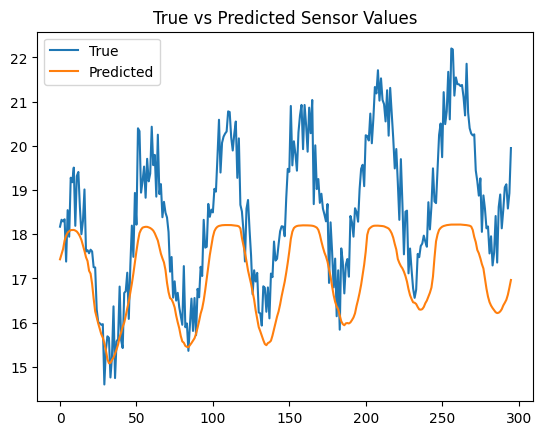

In [10]:
#final training evaluating
# Combine training and validation data for final retraining
full_ds = TimeSeriesDataset(
    np.concatenate([X_train, X_val]),
    np.concatenate([y_train, y_val])
)
full_loader = DataLoader(full_ds, best_cfg["batch"], shuffle=True)

final_model = LSTMForecaster(X_all.shape[2], best_cfg["hidden"], best_cfg["layers"]).to(device)
optim = torch.optim.Adam(final_model.parameters(), lr=best_cfg["lr"])
loss_fn = nn.MSELoss()

for _ in range(40):
    for xb, yb in full_loader:
        xb, yb = xb.to(device), yb.to(device)
        optim.zero_grad()
        loss_fn(final_model(xb), yb).backward()
        optim.step()

# Test evaluation
final_model.eval()
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), best_cfg["batch"], shuffle=False)
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        preds.append(final_model(xb.to(device)).cpu().numpy())
        trues.append(yb.numpy())
y_pred = np.vstack(preds).squeeze()
y_true = np.vstack(trues).squeeze()

MAE = mean_absolute_error(y_true,y_pred)
RMSE = np.sqrt(mean_squared_error(y_true,y_pred))
MAPE = np.mean(np.abs((y_true - y_pred)/(y_true+1e-8))) * 100

print("MAE :", MAE)
print("RMSE:", RMSE)
print("MAPE:", MAPE)

# Create directory to save plots
os.makedirs("/content/output_plots", exist_ok=True)

# Plot and save prediction visualization
plt.plot(y_true,label="True")
plt.plot(y_pred,label="Predicted")
plt.title("True vs Predicted Sensor Values")
plt.legend()
plt.savefig("/content/output_plots/true_vs_pred.png", dpi=300)
plt.show()


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")


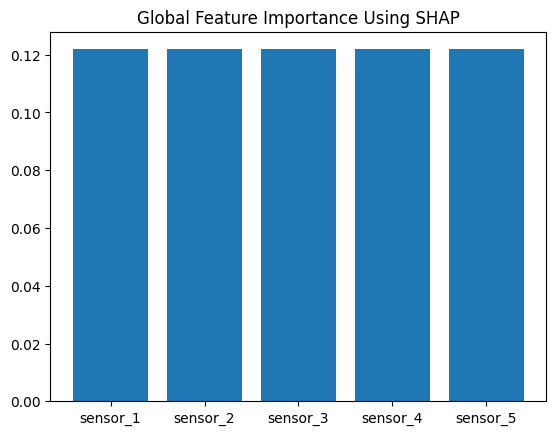

In [11]:
#sharp feature level
background = torch.from_numpy(X_train[:200]).float().to(device)
samples = torch.from_numpy(X_test[:200]).float().to(device)

explainer = shap.DeepExplainer(final_model, background)
shap_values = explainer.shap_values(samples, check_additivity=False)[0]

# Feature importance based on averaged SHAP magnitude
feature_importance = np.mean(np.abs(shap_values), axis=(0,1))
plt.bar(feature_cols, feature_importance)
plt.title("Global Feature Importance Using SHAP")
plt.savefig("/content/output_plots/feature_importance.png", dpi=300)
plt.show()
